# Setup

In order to quantize both the input and output tensors, we need to use APIs added in TensorFlow 2.3:

In [1]:
import logging
logging.getLogger("tensorflow").setLevel(logging.DEBUG)

import tensorflow as tf
import numpy as np
print("TensorFlow version: ", tf.__version__)

2023-05-22 16:56:48.885638: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 16:56:49.259873: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-22 16:56:49.259894: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-05-22 16:56:50.737805: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

TensorFlow version:  2.11.0


# Generate a TensorFlow Model
We'll build a simple model to classify numbers from the MNIST dataset. 
This training won't take long because you're training the model for just a 5 epochs, which trains to about ~98% accuracy.

In [2]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 to 1.
train_images = train_images.astype(np.float32) / 255.0
test_images = test_images.astype(np.float32) / 255.0

# Define the model architecture
model = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(28, 28)),
  tf.keras.layers.Reshape(target_shape=(28, 28, 1)),
  tf.keras.layers.Conv2D(filters=12, kernel_size=(3, 3), activation='relu'),
  tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(10)
])

# Train the digit classification model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_data=(test_images, test_labels)
)

2023-05-22 16:56:53.312179: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-22 16:56:53.312204: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-22 16:56:53.312230: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (RaizelAsus): /proc/driver/nvidia/version does not exist
2023-05-22 16:56:53.313906: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 16:56:53.430930: W tensorflow/tsl/framework/cpu_allocator_impl

Epoch 1/5
1871/1875 [============================>.] - ETA: 0s - loss: 0.2673 - accuracy: 0.9270

2023-05-22 16:57:07.033162: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.


1875/1875 [==============================] - 16s 8ms/step - loss: 0.2669 - accuracy: 0.9271 - val_loss: 0.1098 - val_accuracy: 0.9693
Epoch 2/5
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1013 - accuracy: 0.9712 - val_loss: 0.0783 - val_accuracy: 0.9755
Epoch 3/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.0770 - accuracy: 0.9779 - val_loss: 0.0716 - val_accuracy: 0.9780
Epoch 4/5
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0646 - accuracy: 0.9809 - val_loss: 0.0645 - val_accuracy: 0.9786
Epoch 5/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0560 - accuracy: 0.9830 - val_loss: 0.0666 - val_accuracy: 0.9788


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 12)        120       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 12)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 2028)              0         
                                                                 
 dense (Dense)               (None, 10)                20290     
                                                                 
Total params: 20,410
Trainable params: 20,410
Non-trainable params: 0
____________________________________________________

In [7]:
loss, accuracy = model.evaluate(test_images, test_labels, verbose=0)
print(f'Accuracy: {accuracy*100}')

2023-05-22 17:05:07.539475: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.


Accuracy: 97.87999987602234


# Convert to a TensorFlow Lite model
Now you can convert the trained model to TensorFlow Lite format using the TensorFlow Lite Converter, and apply varying degrees of quantization. 

Beware that some versions of quantization leave some of the data in float format. So the following sections show each option with increasing amounts of quantization, until we get a model that's entirely int8 or uint8 data. (Notice we duplicate some code in each section so you can see all the quantization steps for each option.)

First, here's a converted model with no quantization:

In [8]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmpdllwz6zb/assets


INFO:tensorflow:Assets written to: /tmp/tmpdllwz6zb/assets
2023-05-22 17:05:11.449022: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-05-22 17:05:11.449419: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-05-22 17:05:11.452296: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdllwz6zb
2023-05-22 17:05:11.454431: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-22 17:05:11.454492: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdllwz6zb
2023-05-22 17:05:11.461293: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-05-22 17:05:11.462860: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-05-22 17:05:11.521159: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

In [9]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


## Convert using integer-only quantization
To quantize the input and output tensors, and make the converter throw an error if it encounters an operation it cannot quantize, convert the model again with some additional parameters:

In [10]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(train_images).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant_it = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp4751s5hv/assets


INFO:tensorflow:Assets written to: /tmp/tmp4751s5hv/assets
/home/thai/.local/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:765: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2023-05-22 17:05:16.044497: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-05-22 17:05:16.044525: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-05-22 17:05:16.044817: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4751s5hv
2023-05-22 17:05:16.046669: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-05-22 17:05:16.046688: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp4751s5hv
2023-05-22 17:05:16.050799: I tensorflow/cc/saved_model/loader.cc:2

In [11]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_it)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


## Save the models as files
You'll need a **.tflite** file to deploy your model on other devices. So let's save the converted models to files and then load them when we run inferences below.

In [15]:
import pathlib

tflite_models_dir = pathlib.Path("./mnist_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"mnist_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the integer-only quantized model:
tflite_model_quant_it_file = tflite_models_dir/"test_mnist_model_quant_it.tflite"
tflite_model_quant_it_file.write_bytes(tflite_model_quant_it)

24608

# Run the TensorFlow Lite models
Now we'll run inferences using the TensorFlow Lite Interpreter to compare the model accuracies. 

First, we need a function that runs inference with a given model and images, and then returns the predictions:

In [16]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]
    print(interpreter.get_tensor(output_details["index"]))

    predictions[i] = output.argmax()

  return predictions

### Test the models on one image
Now we'll compare the performance of the float model and quantized model.

Let's create another function to print our predictions:

In [17]:
import matplotlib.pylab as plt

# Change this to test a different image
test_image_index = 0

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
    global test_labels

    predictions = run_tflite_model(tflite_file, [test_image_index])
    print(predictions)

    plt.imshow(test_images[test_image_index])
    template = model_type + " Model \n True:{true}, Predicted:{predict}"
    _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
    plt.grid(False)

Now test the float model:

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


[[ -6.662086   -10.149077    -4.4757547   -0.28167886  -8.945662
  -10.198135   -20.152113     9.790777    -5.489265    -3.4956784 ]]
[7]


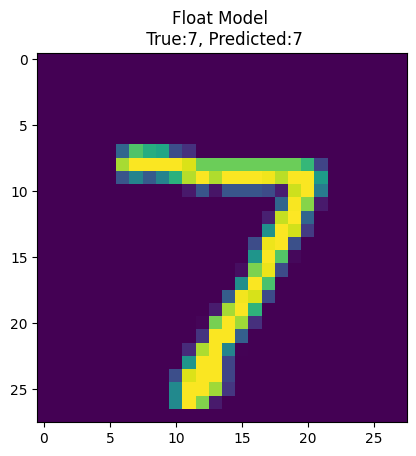

In [18]:
test_model(tflite_model_file, test_image_index, model_type="Float")

And test the integer-only quantized model

[[150 131 163 186 138 131  78 240 157 168]]
[7]


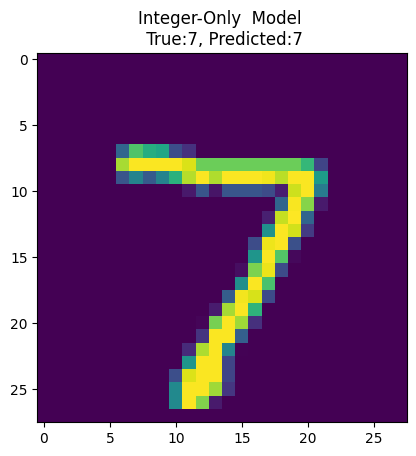

In [19]:
test_model(tflite_model_quant_it_file, test_image_index, model_type="Integer-Only ")

### Evaluate the models on all images
Now let's run both models using all the test images we loaded at the beginning of this tutorial:

In [20]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_labels

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_labels== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

Evaluate the float model:

In [21]:
evaluate_model(tflite_model_file, model_type="Float")

[[ -6.662086   -10.149077    -4.4757547   -0.28167886  -8.945662
  -10.198135   -20.152113     9.790777    -5.489265    -3.4956784 ]]
[[ -9.4168005  -2.8100219   5.733576  -10.226966  -20.000874   -9.9151945
   -3.8179367 -21.666262   -6.07928   -16.855663 ]]
[[-3.5004706  5.475588  -2.845592  -6.4757843 -1.637817  -7.095353
  -5.573045  -3.502335  -3.223416  -8.459757 ]]
[[  5.0736985 -11.313253   -5.505866  -10.155562   -9.760575   -8.360755
   -5.1885557  -8.070564   -8.206498   -9.078798 ]]
[[ -4.7605357 -10.353072   -9.393224   -6.891422    6.666158  -11.135289
   -6.924943   -4.84994    -7.1736374  -3.391257 ]]
[[-4.2282114  5.3395243 -3.6823225 -6.5604186 -1.6683785 -8.158146
  -7.3512497 -0.7703785 -2.613367  -7.276643 ]]
[[-13.289642  -10.106891   -9.834519  -10.37991     2.9283965  -7.0551558
  -10.855525   -7.3405848  -2.142033   -3.9928534]]
[[-19.478216   -7.749162  -10.861842   -6.102923   -0.8147099  -4.046524
  -15.053735   -9.86811    -2.6834302   3.4840353]]
[[ -6.999

[[ -4.7457004  -8.3416815  -9.090659  -13.852482    8.37585   -12.590754
   -5.529004   -5.3479886  -5.349392   -5.4899035]]
[[ -6.7390537 -10.582087   -5.0826774  -6.368012   -3.2180564  -3.8724275
    9.418963  -15.868956   -7.024109  -16.19447  ]]
[[ -7.4548535  -3.3029366   4.816191   -1.8288124 -15.802581  -11.251281
   -8.455371  -13.291936   -1.1119672 -11.904208 ]]
[[ -8.124862  -12.671075   -1.728159  -17.767317   -0.9824792 -12.722998
    4.0044804 -12.673698  -12.012581  -12.594675 ]]
[[ -8.468212  -12.160861   -5.33341    -1.0481693 -11.529248  -13.246985
  -23.775255   11.765536   -6.40593    -2.8889093]]
[[ -7.4570165 -10.469888  -10.350757   -7.9923973  -6.1368055  -9.659818
   -9.169343   -2.6857743  -6.054951    3.219787 ]]
[[-21.385246  -11.235081   -5.9715357   7.0142617 -11.651781   -6.9610105
  -22.126919   -3.2950275  -5.258036   -1.4190464]]
[[ -3.6865516  -12.99587     -0.14839365  -2.9451995   -8.472649
   -8.886031    -8.435142   -19.298834    -9.736772   -15.

[[-3.5251489  6.365635  -4.68366   -7.636891  -1.0221726 -4.663917
  -4.341474  -4.497249  -2.1331642 -8.104938 ]]
[[-15.294988  -22.311848  -14.914449   -4.4322677 -11.277282   10.584419
   -7.751359  -25.48262    -2.4830706  -9.244495 ]]
[[-12.603777   -9.475781  -10.356471    5.6322007 -10.407248   -4.2448583
  -16.998745   -6.194431   -4.8368373  -4.4064865]]
[[-17.715569  -11.972857  -11.473107   -6.824277    7.008806   -3.0863085
   -9.768713   -1.3598007  -4.863106   -1.9835042]]
[[ -3.4112446   -7.5545363   -5.232813   -11.019088    -7.307248
  -14.585461     0.45048824 -14.53195     -1.4471159  -12.957016  ]]
[[-11.518442    -1.8502183   -8.008745    -2.4229748   -0.55066204
   -3.6603858  -12.541924    -2.2542164   -2.8065417    2.4989896 ]]
[[-15.401129   -14.8687105   -8.306487     0.10302703 -13.049668
    7.053579   -12.7415     -12.2437      -2.4295416   -1.2136732 ]]
[[  3.499443  -18.18184    -4.5416517 -10.338948  -21.742634   -4.9421387
   -9.031745  -12.980476  -10.

[[ -6.1617465 -15.362818   -5.4671574  -6.5639973   7.507013  -15.799187
   -9.661334   -7.2523727  -6.6133494  -7.220459 ]]
[[ -5.332461    -8.514276    -2.9376137   -2.0045524  -10.077902
   -9.433787   -17.304934     6.8486285   -6.0583377    0.18738659]]
[[ -5.3327236  -9.699884   -5.9348655 -11.821895   -1.0095283  -7.095589
   10.254294  -10.096844   -5.9858165 -14.244839 ]]
[[ -9.183376  -10.074801   -8.278718   -4.9611635  -2.8863509  -5.9757743
    8.392121  -14.815462   -7.5255475 -11.15     ]]
[[ -5.216055  -13.399682   -8.581948   -6.487465  -10.917178   -4.303621
    6.6228304 -18.214533   -1.2994791 -11.427641 ]]
[[ -7.5318904  -3.3775935  -7.741121   -9.23346     6.7349916  -8.276372
  -11.490477   -3.169473   -3.4838052  -5.2264013]]
[[-11.898727   -14.549881    -3.3453412   -3.441894    -9.367741
   -9.271126   -22.355955     0.18170002  -4.7597523   -1.2633152 ]]
[[-3.974625   4.108637  -4.615172  -6.7078214 -3.7423565 -4.8460774
  -4.0795813 -6.9416614 -1.222264  -8.

[[-18.048061  -17.326618  -12.279836    8.549148  -22.664482   -1.3655491
  -18.545359  -16.625519   -1.8370491  -7.970755 ]]
[[ -0.77341944  -5.793251   -15.045719   -16.560087   -10.381897
  -11.075081     9.611722   -11.101366    -9.939404   -17.80981   ]]
[[-10.959808   -4.304855   -6.658902   -1.004536   -6.256838  -10.848511
  -20.527508    9.732033   -5.0664277  -2.196194 ]]
[[-19.55717   -15.500827  -10.89769    -3.4703164 -13.946596   -8.271725
   -2.9816654 -12.460881    4.552165  -11.686888 ]]
[[ -8.884796    -5.003858    -1.4116585   -0.09837253 -10.050659
  -11.646631   -19.745535     6.7321663   -6.197132    -1.6118714 ]]
[[ -0.06500087  -2.9958727  -14.10946    -16.35428     -3.0249481
  -11.165921     7.142581    -5.4347663   -9.093166   -12.552929  ]]
[[ -3.8930664 -15.029911   -6.7631845 -14.199578    6.6661067 -12.914305
   -3.9767597  -7.7986875  -9.006335  -10.807388 ]]
[[ -6.9660077 -13.455918   -5.3784866  -6.885545  -12.369333   -9.038736
  -12.60941    -8.06425

[[ -6.6846557   -2.9100938   -0.31006956  -8.987746    -2.7328913
   -9.88072     -6.122764    -7.6490526   -1.8997105  -16.49218   ]]
[[ -9.461168   -8.369833   -5.383847    1.0967411 -11.634836   -7.101901
  -20.029526    7.2146573  -6.5793786   0.6553422]]
[[-12.637722  -12.4904375 -10.221155   -8.468771    9.081222   -6.535897
   -9.795651   -3.5298464  -4.210031   -0.8949686]]
[[  0.60607177 -10.463717    -8.568782   -17.680058    -6.4840775
  -10.725229     8.553243   -12.664724   -12.328731   -13.310455  ]]
[[  4.4885573 -14.201979   -8.289758   -8.230416  -27.821424   -4.1301703
   -9.590531  -13.740627   -7.0686455 -16.138367 ]]
[[-6.5881505  5.5243883 -5.7448335 -7.1429677 -4.037925  -4.6934404
  -7.8342147 -2.7037892 -1.0962867 -6.2232637]]
[[-7.8264003  1.9483314 -5.461027  -3.1918738 -3.4716213 -6.848681
  -7.3256493 -6.622564   0.1786489 -5.1347413]]
[[-6.6870565  7.0264316 -3.7253194 -4.0692997 -2.6397069 -4.5382566
  -4.553013  -6.0449004 -2.2309031 -8.506878 ]]
[[  8.3

[[-11.65624   -18.947495   -9.577716   -2.8503315 -16.07364     1.8724849
   -6.149396  -10.916599   -2.9808824  -2.673474 ]]
[[-15.284716  -14.272026   -9.923776   -9.133597    3.9266822  -7.456141
  -13.403167   -9.129712   -5.9833345   0.4743522]]
[[-11.338834   -8.02355    -4.711243   -7.951938   -1.4366132  -4.1271176
    3.0698466 -13.878664   -3.690736  -16.929327 ]]
[[-11.393778  -11.760989  -12.141446  -10.916871    9.905884   -8.524265
   -7.7649827  -2.0492969  -6.708344   -3.2354522]]
[[-10.275719    6.194155   -4.473344   -4.6430793  -2.938385   -5.416131
   -8.117699   -4.935696   -0.7907589  -5.216637 ]]
[[ -8.093983    -6.78938      2.6053553   -2.933439   -12.148077
  -10.684104   -13.803607    -0.45623517  -5.906989    -7.2945967 ]]
[[-15.348896  -12.127462   -6.8067327   9.78489   -12.329819   -4.85381
  -18.04557    -6.956165   -4.338518   -3.1776247]]
[[  3.8125443 -17.036936   -7.8797026 -11.043048  -17.20828    -5.4370413
   -7.3405147 -11.81056    -6.5403953  -6

[[  5.10738   -12.101277   -4.7260904  -9.295205   -9.1458025 -10.070705
   -6.4398117 -10.506299   -6.8407626  -9.07004  ]]
[[-11.433695   -3.8666341  -9.183654   -6.690884   -3.9573228  -2.2980025
    6.3928547  -8.356119   -6.368464  -12.144453 ]]
[[-12.684961   -6.66206   -13.491478   -2.2238877   3.3438745  -4.949988
  -12.023327   -5.220875   -6.1466193   1.6752588]]
[[-13.455684  -23.919184  -11.203647   -4.3054876 -13.546333   -7.8170323
  -11.371984  -20.104204   -1.8473572  -3.017914 ]]
[[ -9.8342285  -4.293517   -9.498323  -10.166315    5.7849774  -7.453755
   -8.995887   -2.8473253  -3.5384731  -3.5453184]]
[[ -9.117097   -3.4416442   5.5246553   0.826886  -17.38786    -8.705319
  -16.53957    -5.9106636  -2.8488812 -12.300983 ]]
[[ -6.3115125 -14.12152    -9.73327   -10.045671   -2.7247736  -6.2213
  -14.358136    4.297154   -4.2324705   2.396301 ]]
[[-10.367775  -20.966295    5.7666078  -1.9843625 -19.794098  -11.320213
  -19.362371  -10.790335   -5.8947554 -10.324414 ]]


[[-15.157013  -20.983864  -10.63332    -4.515869   -1.4015728  -6.403277
  -16.32649    -0.8298528  -5.045858    4.7867994]]
[[-17.72978   -18.421286  -10.6729965  -0.5662405  -3.6419337  -6.279653
  -16.060741   -4.6977305  -6.6713586   5.2423162]]
[[-15.313116  -13.529001  -11.620378   -3.4673598  -1.8489832  -4.9603753
  -10.07109    -3.2021408  -5.0285773   5.1349444]]
[[-4.438155   2.011009  -2.6472635 -6.676003  -4.3936863 -7.1283975
  -5.600091  -3.0221076 -2.4062953 -8.493241 ]]
[[  7.6543374  -19.675863    -3.8776407  -13.742718   -10.7293625
  -14.951508    -3.179496   -11.866322    -0.97596747  -8.81195   ]]
[[-10.073385   -7.4919653   1.1025038  -8.114895   -7.258824   -8.775339
  -11.647038   -1.3198045  -5.984105   -9.0943775]]
[[  6.5641766 -20.470526   -5.984807  -12.124879  -19.218172  -10.480525
  -14.661624  -13.9413185  -6.161994   -7.293248 ]]
[[ -5.9371853 -15.410491    5.4211407  -4.204185  -14.683702  -11.737141
  -12.013888   -4.419206   -1.1799325  -9.527409 ]

[[-11.665157  -16.337835   -2.8464508  -5.1472173 -14.049559   -8.154111
  -18.149498   -9.664331    4.138748   -2.5672586]]
[[-6.8525057  6.6495447 -4.0949893 -4.3582525 -1.7327346 -7.028849
  -4.6025586 -5.205721  -1.8530092 -7.6583185]]
[[-11.266122   -7.122432    8.174349   -1.4997817 -19.301888  -10.751804
   -8.343336  -15.878201   -5.5315676 -24.38139  ]]
[[-11.989955    -9.207517     6.5762887   -0.7765209  -28.957092
  -12.050741   -14.340016   -15.987214     0.12788458 -14.662681  ]]
[[-12.920797  -21.897104   -7.7595468  -6.98315   -22.55083     7.5750813
  -16.636814  -20.014353    2.494544   -9.135128 ]]
[[-14.001623  -22.626791  -13.6244955 -11.983696  -12.298313    9.760901
  -18.02179   -10.826741   -1.2732762  -1.1858381]]
[[-16.890652  -14.381293    1.0674245  -0.9590835 -15.862197  -11.497482
   -4.5053577 -20.287693   -3.6239603 -26.422241 ]]
[[ -9.183739  -11.036237   -7.2107434   7.7446585 -20.191544   -2.760851
  -11.425363  -13.241607   -6.977889   -3.4697344]]


[[  6.7114425 -18.401793   -5.215687  -14.203357  -21.946796   -7.1904306
   -8.589665  -10.748783   -4.0381    -11.976277 ]]
[[-3.3152065  3.5342278 -2.179274  -6.596473  -4.411579  -6.118639
  -4.482892  -7.580103  -2.9063506 -9.289743 ]]
[[-15.207082    -3.0494308    9.778205     0.22241656 -26.9956
  -13.771463   -12.243993   -14.97485     -2.5973017  -21.453144  ]]
[[-20.310484  -11.870791   -5.478272   10.871555  -26.67653    -7.709416
  -23.21558   -14.408775   -5.615512   -7.1986628]]
[[-11.989788   -9.579573   -9.845485   -9.024914    7.0238395  -5.3929996
  -13.719037   -5.4945083  -3.6725295  -2.1782725]]
[[-19.36377   -19.795218  -17.258713   -1.4512533 -15.915178    7.973679
  -13.284553  -20.453451   -2.084853  -16.041037 ]]
[[ -4.264892  -10.192774   -6.4505854 -18.45489    -7.050571  -13.927509
    8.704195  -15.625257  -11.787727  -22.98714  ]]
[[ -5.439366  -10.95003    -3.150796   -4.533458   -8.98773    -7.6752877
  -20.576054    7.51356    -6.3804517  -1.1711379]]


[[-12.351267   -9.017995   -7.64006     3.7054176 -12.617745   -4.6669383
  -14.176246  -14.899912   -3.4723125  -4.221568 ]]
[[ -9.4643755  -9.747421   -4.9431686  -7.6037383  -7.33561   -12.13319
  -10.073024  -11.120464    6.6772647 -12.721233 ]]
[[ -7.671126  -10.217103  -10.932586   -9.751058   -1.7029027  -4.147593
   10.343428  -10.225715   -9.583723  -15.926033 ]]
[[-16.016033  -10.4633255 -11.476251    5.8927493 -20.06736    -2.1510236
  -17.34404    -4.981813   -3.784875   -9.80279  ]]
[[-15.785874  -14.99873   -10.199355   -2.090689   -3.1659205  -8.04162
  -15.647113   -5.3123865  -5.2495146   6.3600683]]
[[-18.337564  -14.478164  -11.162298   -1.3005742  -1.9313161  -7.196011
  -13.04687    -7.109012   -4.504086    7.2920575]]
[[ -6.646953  -21.930502  -10.748401  -12.656711  -18.246878    9.899394
   -9.750372  -20.028637    1.5634886  -7.082279 ]]
[[-16.100033  -18.790642  -10.80372    -1.5147434  -6.4265876  -4.6253185
  -15.443149   -2.5581927  -3.559054    7.4927397]]

[[-10.738761  -23.244661  -15.521295   -2.922083  -18.204134    9.398595
   -5.8656006 -20.588854   -3.3970942  -6.0916595]]
[[-10.486584  -14.111722   -6.659849   -9.087701   -6.502992   -6.9683375
   10.55768   -15.879565   -7.6970415 -16.790668 ]]
[[ -8.945541   -11.53758     -8.684403    -4.260651    -5.685286
  -10.031953   -21.284153     6.5309234   -4.908579    -0.37340295]]
[[-12.382963  -14.2253275  -4.575716   -4.6312976 -15.081829   -9.400646
  -16.121988  -11.662502    6.202293   -8.2360525]]
[[-13.33503   -22.832487  -11.357511   -6.8224115  -5.2129316  -8.102278
  -20.545399   -1.1253666  -3.5191417   3.7921965]]
[[  9.395319  -11.867829   -4.596822  -11.948993  -12.396728   -9.369583
   -5.947438   -8.75708    -5.7550707 -12.524176 ]]
[[-11.95212   -12.185264   -5.1009045  -4.6267533 -13.809389   -7.230949
  -16.282417   -6.8035407   5.3218184  -6.9517975]]
[[-14.851009   -16.31427    -10.677295     7.7211413  -22.601074
   -0.36831847  -9.809667   -18.542688    -2.07602

[[-3.5120497  3.9100213 -1.9403319 -6.818569  -3.554658  -8.388717
  -7.301925  -8.309379  -2.5268345 -8.308777 ]]
[[ -9.015305  -19.479525    6.547111   -2.939053  -18.876041  -13.6195755
  -17.91027    -7.222384   -6.1756563 -14.265011 ]]
[[-13.691086   -15.800446   -13.09485     10.00481    -21.91843
   -4.5533814  -26.325089    -4.8517184   -6.9905806   -0.02853828]]
[[ -9.583891  -18.436205   -9.258763   -9.9924345   5.724787  -11.101694
   -7.032072   -9.713033   -4.755314   -7.4924407]]
[[-10.800634  -15.030269  -10.710731   -3.5158827 -10.757217    6.898552
   -6.060933  -10.837703   -7.416007   -7.115722 ]]
[[ -8.419863  -13.698867   -6.833251   -7.5778265  -5.284507   -3.7430582
   10.389907  -16.321268   -7.3739753 -13.148806 ]]
[[ -7.1911683 -25.885174   -9.081496   -8.070769   -4.3066497  -9.295108
  -10.467359   -6.7200494  -4.172005   -0.6504314]]
[[  6.639547   -19.657824     0.03170733 -10.858507   -11.267046
  -15.419995    -5.865987   -12.655134    -8.173289   -13.03

[[ -6.621663    4.945689    0.6058157  -5.1486154  -4.6606307 -10.575228
   -6.8236256  -4.904581   -2.7724397  -9.661356 ]]
[[-10.99689    -9.715554   -8.645258    6.0669684 -14.405678   -1.7558031
  -15.095717  -10.055125   -6.773574   -4.85068  ]]
[[ -8.107928  -24.173552   -3.9918594  -9.085527  -11.647369   -3.5820627
   -9.966266   -5.3285375  -3.8529396  -7.755182 ]]
[[ -8.360355  -10.113974   -6.2687793   9.229972  -23.903385   -4.835505
  -17.820059  -11.408228   -5.7390814  -9.100886 ]]
[[ -8.325728  -12.942582   -5.8864374 -11.213422   10.635632  -15.317186
   -8.31532    -4.998168   -4.8492765 -13.325428 ]]
[[ -8.522547  -13.350812   -6.3496685   5.136622  -24.909386   -7.1571665
  -21.153008   -9.54932    -4.936208  -10.69404  ]]
[[ -7.1195493    6.000597    -0.07192989  -5.7894635   -1.3523828
  -12.180342    -6.213722    -4.178843    -3.530717    -8.868544  ]]
[[-13.047253  -26.644579  -11.555539   -2.6043825  -9.534259   -9.522758
  -20.437897   -4.1357613  -3.4217672  

[[ -1.7764454 -11.671778   -5.2519684 -10.990615   -8.576906   -7.156404
  -11.438521   -7.9946747   4.2984047  -8.272996 ]]
[[  7.803417  -18.57129    -2.45257   -10.110973  -12.8471575 -13.092174
   -5.042944  -12.686677   -3.4681964 -10.230254 ]]
[[ -2.3044994   3.2264342  -0.6117714  -3.718122   -3.8057594 -12.947903
   -9.009107   -8.532206   -2.0904212  -9.165034 ]]
[[ -8.929295  -14.208604    6.7224684  -6.1252837  -8.05755   -10.668251
  -16.687748   -6.2914996  -7.394079   -5.234819 ]]
[[ -7.249313  -14.072656   -5.478938    2.5048888  -5.038672   -5.019833
  -16.876783  -10.3765335 -11.076734   -1.3612328]]
[[-10.0335865 -16.409697  -12.074763   -3.6721928  -9.984584    0.9496308
   -4.616477  -11.631735   -1.6693984 -11.098798 ]]
[[ -3.5715075 -13.453866   -4.8959594  -8.715031   -9.934447   -3.4265888
    4.3768315 -19.133934   -5.4412136 -15.36046  ]]
[[ -8.292869    -9.509479   -11.255216    -5.8734117   -4.8872113
   -6.842543   -22.128254     8.495729    -5.717755     0

[[  3.7816873 -18.628717   -2.07824    -6.347704  -14.185118  -13.607559
   -9.24087    -8.420043  -10.973189   -8.757664 ]]
[[-5.4766426  3.0602772 -2.9367938 -4.0634336 -4.550098  -6.8032513
  -9.797409  -4.085922  -2.4783895 -6.6015754]]
[[ -9.012682  -10.117624    2.5356202  -7.20085    -0.7099277 -12.44894
  -16.795391   -5.9342823  -8.390205  -11.149195 ]]
[[-11.225502  -12.5359745  -9.079483    4.5081387 -16.913712   -2.270759
  -22.224636   -5.4607186  -5.0109987  -7.4485765]]
[[-10.203248   -7.684978  -10.361064  -10.131675    7.3626657  -8.717464
   -9.79239    -8.250208   -3.73739    -5.8631754]]
[[ -8.096159  -12.280421  -11.86152    -6.2348537  -8.599434   -8.630794
  -21.70286    10.269434   -7.018877    1.0985461]]
[[ -9.78956   -13.628097   -8.4893675 -12.046622  -16.158325   -4.1640344
  -15.131307  -11.450611    7.7730284 -11.343731 ]]
[[-15.094654   -13.035972   -14.162896    -5.067822    -0.41402057
   -3.4533644  -20.909367    -0.9725587   -2.861816     3.7608492 ]

[[-3.2608647  4.956375  -1.3057926 -5.7127404 -2.7140636 -8.09373
  -7.2793436 -3.6581764 -3.184431  -8.510535 ]]
[[-12.007326  -15.395886   -6.509996   -4.23807   -16.714123   -8.532299
  -14.75822    -7.5470204   5.7495604  -6.25471  ]]
[[-12.649962  -18.196764   -9.02946    -6.776549  -14.595364   -6.2110877
  -13.509919   -8.591684    5.8917313  -3.4707415]]
[[ -8.707008   -4.911811   -7.7512836  -2.622326   -5.35455    -8.911983
  -19.3583      6.789058   -4.176665   -0.6774832]]
[[-16.581486  -17.44692    -8.528149   -4.2763867 -11.453999   -5.489618
  -17.26168    -6.8223114   6.138315   -4.535603 ]]
[[-4.724624   4.7014875 -2.1715112 -4.331143  -4.8522773 -8.473122
  -5.664366  -7.9961205 -1.3848646 -9.172804 ]]
[[  6.5499864 -11.677609   -3.2030034  -8.299287  -10.549076  -12.061775
   -6.06065   -12.406506   -6.5988364 -10.287653 ]]
[[  6.711819  -13.853711   -4.3448105  -7.923674  -14.735754   -9.353639
   -7.0179157  -9.314871   -5.975016   -8.8974495]]
[[ -2.6469646  -8.80

[[-16.815777  -11.716817   -6.9689183   9.855163  -10.985476   -4.243603
  -18.549133   -7.7079926  -3.855342   -2.2331855]]
[[-13.381205  -13.009847  -11.418584   -8.536358   10.502979   -7.5348334
   -7.8530674  -7.408985   -5.0277433  -4.9995494]]
[[ -7.269946    -9.269456    -5.570697    -0.53415984  -9.123108
  -12.359501   -20.897568    11.271528    -8.687738    -6.0818086 ]]
[[-15.292094  -26.982218   -6.4883213  -4.521908  -22.667938   -4.191074
  -13.573655  -17.283386    8.495713   -7.235306 ]]
[[-16.699364  -20.237427  -13.152278   -5.776778   -9.700968   -2.6470032
  -12.945069   -2.418043   -2.8747392   7.1013904]]
[[ -7.180915    -5.267479    -4.3337727   -0.38799304  -8.319651
   -9.772388   -19.555674    11.279652    -6.4928226   -3.162973  ]]
[[-17.716532  -20.377377  -15.577687   -0.3285901  -9.655735    8.36249
  -17.803463  -13.438152    0.6047849  -2.2997777]]
[[-10.754772  -15.755628  -17.761992   -3.32526    -5.900988    6.326689
  -14.614489   -8.803792   -4.168

[[ -2.2376392 -12.012721   -5.9008284 -11.737247    8.113876  -15.052126
   -2.9702704  -7.4825063 -10.471714  -16.844292 ]]
[[ -8.6012    -12.221487    3.5779328  -1.0229881 -23.430347  -10.936232
  -16.154566   -4.3368807  -1.7284406  -5.5994606]]
[[-14.167707  -17.216175   -9.752299   -6.3648806  -6.8978934  -6.124767
   -8.707218   -9.358267    1.7454635  -4.9702687]]
[[ -6.553004    5.443677   -1.948506   -6.166663   -2.226395  -11.037552
   -9.685229   -2.6666465  -3.292852   -7.9872212]]
[[ -4.1333237  -4.080037  -12.529307   -7.102371  -11.902258    5.86021
   -9.099577  -13.647791   -2.3339777  -7.9228354]]
[[-5.052009   5.9009924 -2.3187819 -6.500713  -1.8029557 -8.772915
  -8.483525  -1.5762646 -3.924937  -8.518318 ]]
[[  1.0991517   -7.8446746   -0.19636108 -11.873526    -4.0667596
  -15.886931    -4.388676    -7.2529464   -2.5288095   -9.69159   ]]
[[ -9.349686   -6.1587996   5.4842944  -0.9989844 -19.736084  -11.44953
  -10.6629305 -12.2539625   1.0061274 -11.133894 ]]
[[

Evaluate the integer-only quantized model:

In [22]:
evaluate_model(tflite_model_quant_it_file, model_type="Integer-Only")

[[150 131 163 186 138 131  78 240 157 168]]
[[136 171 218 132  78 133 166  69 154  95]]
[[168 216 171 152 178 148 157 168 170 141]]
[[214 125 157 132 134 141 159 143 142 137]]
[[161 130 136 150 223 126 149 161 148 169]]
[[164 216 167 151 178 143 147 183 173 148]]
[[114 131 134 131 203 148 128 147 175 165]]
[[ 81 145 128 154 183 165 105 133 173 206]]
[[148  86 127 130 137 193 190  89 172 127]]
[[118  74 125 148 179 141  77 175 167 200]]
[[224  88 161 121  62 129 152 121 162 153]]
[[161 138 109 125 116 131 224  95 144 102]]
[[121  88 120 165 178 143 114 174 157 215]]
[[222  93 135 123  97 151 152 139 169 155]]
[[144 214 152 171 167 159 147 150 184 139]]
[[106 101 145 166  77 213 125 119 167 118]]
[[138  85 124 153 171 137 116 180 157 207]]
[[150 114 160 191 119 137  63 251 141 157]]
[[100  81 125 169  85 164 106  93 177 118]]
[[136 144 133 138 240 135 143 175 168 163]]
[[141 134 121 160 184 144  88 186 166 201]]
[[119  99 123 145 148 187 229  81 167 130]]
[[149 162 116 118 168 132 220 14

[[ 85 104 153 232 107 149  81 150 167 150]]
[[143 110 178 159 104 128  77 212 175 147]]
[[ 95  48  93 178 134 221 113 131 179 196]]
[[148 113 139 118 231 145 151 148 130 146]]
[[140 150 138 132 222 139 127 159 175 140]]
[[169 212 172 155 172 150 154 159 170 142]]
[[107  90 129 151 129 157 140 151 192 167]]
[[159 214 167 154 179 137 142 174 168 159]]
[[106 114 151 206  79 146  94 130 142 102]]
[[131 134 154 146 127 146  84 152 216 163]]
[[162 215 167 150 183 147 153 174 166 153]]
[[127 135 206 182 146 139 100 187 133 121]]
[[142  45 147  95 105 201 176 110 193 167]]
[[174 188 173 150 145 113 128 153 204 119]]
[[206  87 154 137 121 123 137 133 158 149]]
[[168 134 135 128 178 131 238 115 116 147]]
[[128 165 228 170  77 103 111 149 175 119]]
[[158 212 169 155 162 155 149 170 185 148]]
[[162 215 155 134 183 154 161 155 184 143]]
[[107 173 182 181 174 158 148 162 153 162]]
[[168 221 161 146 181 162 164 162 176 143]]
[[103  65 105 163 125 244 145  48 174 137]]
[[118 135 131 218 130 163  94 15

[[112  67 116 160 117 232 139  82 178 162]]
[[131 162 129 157 165 156 131 151 191 165]]
[[182 145 125 122 144 112 209 132 164 105]]
[[ 99  42  94 185  73 227  97 130 168 175]]
[[141 114 144 141 155 176 238  76 160 107]]
[[231 100 161 130  83 123 120 143 161 148]]
[[130  49 121 160  65 164 154 109 214 138]]
[[130 123 133 138 162 164 232 104 168 127]]
[[134 147 137 162 153 125  94 228 163 185]]
[[117 132 153 213 102 178  82 171 157 171]]
[[177 143 126 122 146 152 244 126 140  94]]
[[116 143 117 143 220 137 134 175 161 172]]
[[139  93 138 163 176 150 142 165 155 201]]
[[146 137 126 135 237 153 141 155 155 152]]
[[140 132 137 140 152 147 208 137 159 158]]
[[153  96 153 143 127 166 194  91 184  81]]
[[107 111 162 223  77 143 106 114 187 150]]
[[156  63 192 118  66 153 137  94 170 129]]
[[123 143 128 135 236 149 148 159 150 164]]
[[133 222 158 165 177 160 141 176 175 159]]
[[213  47 161 133 112 130 151 140 123 180]]
[[136 209 179 159 175 147 158 159 169 159]]
[[148 157 155 164 192 143 159 15

[[ 74 142 160 171 132 141  78 172 200 148]]
[[112 113 123 201 128 173 101 138 164 148]]
[[112 120 171 160 209 116 113 150 138 170]]
[[ 99 120 129 174 163 130 117 152 154 223]]
[[124 109 135 178 123 222 144 111 161 178]]
[[143 126 218 188  95 117  98 172 158 130]]
[[138 149 166 169 121 133 124 137 198 151]]
[[154 227 161 154 186 150 163 180 169 151]]
[[104  76 120 178 117 208 149 137 167 176]]
[[115 134 151 223 122 150 105 176 165 169]]
[[125 178 156 195 148 142  90 216 177 172]]
[[121 150 129 164 175 165 109 175 175 213]]
[[122 150 144 154 225 147 146 124 162 168]]
[[ 99 104 231 167 129  77  87 125 146  78]]
[[107 124 157 165 152 203 154 132 170 151]]
[[168 150 131 155 177 150 224 146 134 124]]
[[167 110 175 165  68 145 119 169 188 130]]
[[109  70 117 160  83 255  79 100 192 143]]
[[109 142 136 156 172 158 112 176 165 216]]
[[ 91 108 129 218 109 156 125 128 167 167]]
[[177 116 122 114 134 202 140 155 147 159]]
[[111 119 129 166 193 137 147 160 154 212]]
[[ 90 123 183 187 118 134  87 20

[[119 194 207 146 147 128 115 144 173 120]]
[[ 86  94 119 255 117 164  61 162 140 182]]
[[229 106 164 111 101 119 177 104 154 139]]
[[156 135 217 158 127 114 136 149 174  97]]
[[172 113 153 173 143 129 167  98 185 121]]
[[122  97 112 133 124 228  79 122 175 179]]
[[135  90 136 164 177 112 136 171 150 190]]
[[189 118 117  97 159 117 226 137 119 113]]
[[111  96 124 163 174 127 101 173 180 206]]
[[158 142 145 157 151 139  95 216 160 187]]
[[134 118 235 147 113 102 115 144 154  96]]
[[154 218 157 153 180 161 162 164 182 151]]
[[ 98 106 164 227  67 149  91 122 180 147]]
[[106 134 140 148 177 161 229 113 150 120]]
[[149 138 144 145 200 133 180 147 157 162]]
[[149 221 157 160 182 139 149 183 170 159]]
[[129  96 156 138 113 179  86 125 211 151]]
[[141  93 226 181  81 135 116 133 159 103]]
[[129 160 133 145 241 133 136 164 175 159]]
[[231 100 145 109 103 145 149 139 170 132]]
[[113  92 109 160  96 210 160 108 172 157]]
[[161 215 166 154 180 143 146 186 170 156]]
[[212 104 141 129  95 152 114 15

[[170 218 165 146 178 153 168 161 176 140]]
[[135  83 140 143  90 176 154 118 208 151]]
[[ 64  78 131 245  99 161  83 120 167 144]]
[[118 154 122 148 230 144 124 162 178 179]]
[[211 124 149 150 113 141 150 131 163 148]]
[[ 71 157 172 183 161 143  89 210 162 118]]
[[ 98 127 146 177 114 142 114 156 212 149]]
[[104 149 156 214 129 157  96 201 167 168]]
[[106 112 127 181 184 151  92 174 167 220]]
[[143 139 174 203  99 144 123 143 165 149]]
[[132  95 138 174 197 160 161 138 146 158]]
[[172 153 123 100 175 108 197 137 140 142]]
[[ 80  65 110 203  98 222  79 154 167 182]]
[[184 142 106 103 172 116 227 155 123 114]]
[[118 188 232 198 102 110 133  93 152  82]]
[[149 177 177 187 130 145 128 171 165 151]]
[[115  70 125 165 176 156 126 153 166 223]]
[[140 141 222 166 143 119 138 148 154 124]]
[[148 147 134 130 171 152 255 121 139 109]]
[[220 124 150 129 124 140 169 139 166 139]]
[[213 104 146 147  94 147 140 134 146 136]]
[[168 109 126 110 113 144 216  99 160 116]]
[[151 213 148 149 177 162 145 16

[[163 117 165 146 130 127 128 133 212 151]]
[[162 214 183 155 175 138 140 167 166 145]]
[[113  75 113 174  86 228 103 115 166 157]]
[[116  61 118 168 151 153  89 170 165 222]]
[[237  99 166 112 117 111 189 109 165 133]]
[[134 125 143 150 173 166 240  94 148 110]]
[[177 111 129 146 229 120 152 154 137 167]]
[[106  83 136 230  72 168  57 116 184 182]]
[[140 125 147 181 157 151 221  95 150 111]]
[[139 102 138 216  76 171  99 118 182 168]]
[[107 111 148 223  85 170  82 109 183 172]]
[[133 143 139 161 154 150 113 166 190 174]]
[[165 214 183 151 172 142 145 153 167 140]]
[[147 128 129 149 227 138 136 175 158 157]]
[[155 128 137 156 171 147  95 219 154 186]]
[[ 81  54 116 166 106 244 125  68 171 142]]
[[157 112 148 162 146 137  76 232 152 185]]
[[141  74 233 169 105 115 110 153 150 135]]
[[160  54 214 168  82 135  98 134 135 139]]
[[234  95 148 114  94 135 157 145 168 151]]
[[230  74 143 121  79 140 150 120 169 154]]
[[156 219 161 165 173 145 156 158 179 148]]
[[156 115 139 160 153 152 104 22

[[117  67 144 227  51 165  79 103 183 174]]
[[154 128 144 119 174 122 243 125 147 101]]
[[129 116 155 163 121 145  98 132 218 148]]
[[155 107 145 179 144 150  67 227 147 187]]
[[220 102 157 133 121 119 166 103 133 127]]
[[151 121 134 145 228 121 128 163 157 158]]
[[131 118 226 174 130 106 110 116 177 122]]
[[143 154 142 158 167 139  97 229 162 187]]
[[164 127 127 138 244 122 155 156 159 155]]
[[169 114 124 135 175 134 109 237 149 181]]
[[123  90  96 165 112 236 128  90 164 159]]
[[118 114 118 142 234 138 123 153 167 180]]
[[110 107 135 221  95 159  78 113 163 155]]
[[190 100 142 143 232 113 145 152 142 156]]
[[117  96 231 167  98 114  80 124 177 122]]
[[136 103 160 157 118 134 111 126 215 155]]
[[168 217 177 153 172 143 153 157 172 137]]
[[132  86 123 176  87 212 169  77 154 123]]
[[157 219 182 154 178 140 135 166 162 147]]
[[135 112 217 151 147  99 102 161 147 117]]
[[224  92 154 120 101 121 171 111 151 150]]
[[ 97 137 219 161 131 125  92 116 153 117]]
[[114  90 119 161 113 231 144  7

[[156 217 178 163 176 131 143 154 173 137]]
[[115 133 217 168 104  86  89 175 173 112]]
[[139 108 134 150 145 138 232 114 122 108]]
[[124 118 130 127 234 106 101 170 161 164]]
[[122 133 207 186  85 111  51 188 152 134]]
[[136  95  93 150 135 244 128  73 163 154]]
[[136 120 220 175  94 129  66 170 146 136]]
[[114 125 157 236  85 154  91 157 171 155]]
[[167 144 153 129 177 151 234 115 148 101]]
[[163 126 137 129 159 147 230 126 146 120]]
[[160  87 121 152 141 223 143  91 162 153]]
[[227 112 176 132 162  94 176 135 173 122]]
[[224 136 177 140 150 127 162 146 169 117]]
[[139 143 229 148 124 113 104 166 154  99]]
[[131 132 156 153 141 141 100 146 214 147]]
[[162 213 179 160 173 129 144 160 174 138]]
[[150 118 152 141 155 147 244 104 139 108]]
[[168 216 178 150 172 141 148 157 168 137]]
[[231 117 177 139 146  94 176 110 170 116]]
[[118 137 120 137 236 118 139 163 173 143]]
[[117 138 162 231  63 142  55 171 170 156]]
[[163 211 185 158 171 138 137 151 169 141]]
[[147 114 160 144 152 148 225 10

[[133  79 148 219  82 137 108 100 169 156]]
[[147 131 112 138 221 132 156 169 188 148]]
[[163 148 158 166 147 108 115 129 205 130]]
[[137 120 141 122 138 133 249  84 144  88]]
[[138 116 151 224  70 155  99 135 141 141]]
[[133  24 145 115  86 156 116  83 224 149]]
[[204  67 159 132 137 128 162 146 130 147]]
[[108 111 117 171 170 150  68 186 167 211]]
[[137 124 145 142 163 140 231 118 129 111]]
[[136 126 202 159 122 124 114 147 169 113]]
[[171 198 165 121 179 138 150 155 178 124]]
[[224  70 168 118  93 127 162 137 137 140]]
[[173 198 174 163 159 134 150 147 182 143]]
[[223  83 177 134 121 126 139 150 152 144]]
[[142 129 159 135 165 158 239  99 143 118]]
[[146  98 231 157 126 126 125 114 140  87]]
[[121 108 158 251  70 166  78  93 147 152]]
[[142  71 163 143 109 136 116 137 224 152]]
[[116 132 135 169 169 156  88 182 182 212]]
[[225  75 180 128 126 126 179 114 158 126]]
[[153  92 180 170 119 157  67 221 155 165]]
[[128 132 212 183 126 125  90 172 144 133]]
[[106 108 136 235  90 162  43 12

[[127 121 135 221  98 173 106 122 170 159]]
[[140 129 154 144 127 132 110 157 220 134]]
[[137  91 109 131 124 234 151  97 171 146]]
[[139 122 127 134 239 141 141 159 158 164]]
[[112 115 220 156 128 109 116 115 175 105]]
[[229  91 168 120 137 112 178 128 170 136]]
[[129 126 120 156 191 132 140 160 156 199]]
[[127 137 141 175 141 139  48 249 156 162]]
[[154 123 136 128 178 108 234 120 128 114]]
[[137 131 183 188 107 126  48 228 158 178]]
[[172 119 139 141 231 120 138 162 150 161]]
[[141 216 181 161 174 122 127 185 160 146]]
[[148 116 159 144 177 126 232 113 130 100]]
[[142  98 190 164 127 133  98 118 156 123]]
[[153 115 161 131 160  96 223 119 145 111]]
[[146 141 162 178 142 130  58 247 148 172]]
[[160 219 185 157 179 133 135 166 166 138]]
[[108  54 118 163 148 147 107 161 171 215]]
[[147 108 148 141 123 141 121 142 220 147]]
[[226  89 171 122 138 103 128 156 160 133]]
[[163 126 155 132 177 127 224 134 148 123]]
[[130  60 130 135 164 136  99 169 178 204]]
[[140 124 118 129 239 144 135 15

[[149 168 138 157 193 137 127 183 159 163]]
[[151  87 144 136 137 185 212  74 166  91]]
[[129  63 161 134 128 131 211  86 144  63]]
[[159 199 169 144 163 144 145 165 168 115]]
[[147 219 183 155 169 132 138 161 165 141]]
[[123 123 136 234  94 160 113  87 161 162]]
[[135 106 218 175 107 121  83 107 129 113]]
[[134 220 165 162 159 128 120 177 157 143]]
[[193  60 170 132 123 119 132 158 151 152]]
[[236  77 173  90  98 133 154  84 179 116]]
[[153 214 168 158 180 141 141 177 169 143]]
[[124 136 223 195  54 100 113 115 191 124]]
[[125 119 143 234  58 181 106 112 168 165]]
[[142 116 126 129 245 121 144 180 156 144]]
[[151 166 156 181 149 137  86 239 152 178]]
[[120  92 149 159  86 153 137 114 222 141]]
[[123 111 115 178 179 156 143 160 157 204]]
[[217  98 166 131 136 103 132 148 175 129]]
[[150 216 163 155 179 144 132 178 167 145]]
[[129 130 196 182  63 132 101 148 195 151]]
[[141 118 139 224  89 174 118 112 158 152]]
[[165 137 130 139 222 136 152 164 149 163]]
[[165 153 141 135 112 206 158  8

# Get model parameter

In [74]:
print(model.trainable_variables)

[<tf.Variable 'conv2d_4/kernel:0' shape=(3, 3, 1, 12) dtype=float32, numpy=
array([[[[-1.1798986 , -1.1821756 , -0.7605325 ,  0.42580953,
           0.01117041,  0.4167813 , -0.14897297,  0.33563063,
           0.1286922 , -0.9515333 , -0.15662205,  0.32970515]],

        [[-0.5856181 , -0.8276254 , -0.79739904, -0.08104774,
           0.07222456, -0.42060205,  0.5175032 ,  0.6700543 ,
           0.4812081 , -0.64884126,  0.22643429,  0.06439738]],

        [[ 0.51491106, -1.2131869 , -0.5952444 ,  0.04238663,
           0.01132497, -0.64634514,  0.57816267,  0.25727823,
          -0.6913044 , -0.86042553, -0.04848505, -0.03539857]]],


       [[[-1.0657593 ,  0.29089656, -0.06403342, -0.03581551,
          -0.22352107,  0.3875414 ,  0.06647286, -0.24192172,
           0.5317171 , -0.23773918,  0.19994004, -0.14594798]],

        [[ 0.30603167,  0.15121561,  0.33498368, -0.17238025,
           0.2241368 ,  0.1919332 , -0.05844301, -0.01908302,
           0.4657244 , -0.0948131 ,  0.314

In [75]:
# Helper function to run inference on a TFLite model
def test_tflite_model(tflite_file):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  all_tensor_details = interpreter.get_tensor_details()
  interpreter.allocate_tensors()
  print("TENSOR NAME!!!")
  for tensor_item in all_tensor_details:
    print("%s" % tensor_item["name"])

  print()
  print("TENSOR WEIGHT!!!")
  for tensor_item in all_tensor_details:
    print("Weight %s:" % tensor_item["name"])
    try:
      print(interpreter.tensor(tensor_item["index"])())
    except:
      print("###: An exception occurred")

In [76]:
test_tflite_model(tflite_model_quant_it_file)

TENSOR NAME!!!
serving_default_input_4:0
sequential_4/reshape_4/strided_slice/stack
sequential_4/reshape_4/strided_slice/stack_1
sequential_4/reshape_4/Reshape/shape/1
sequential_4/reshape_4/Reshape/shape/3
sequential_4/flatten_4/Const
sequential_4/dense_4/BiasAdd/ReadVariableOp
sequential_4/dense_4/MatMul
sequential_4/conv2d_4/BiasAdd/ReadVariableOp
sequential_4/conv2d_4/Conv2D
tfl.quantize
sequential_4/reshape_4/Shape
sequential_4/reshape_4/strided_slice
sequential_4/reshape_4/Reshape/shape
sequential_4/reshape_4/Reshape
sequential_4/conv2d_4/Relu;sequential_4/conv2d_4/BiasAdd;sequential_4/conv2d_4/Conv2D;sequential_4/conv2d_4/BiasAdd/ReadVariableOp
sequential_4/max_pooling2d_4/MaxPool
sequential_4/flatten_4/Reshape
StatefulPartitionedCall:01
StatefulPartitionedCall:0

TENSOR WEIGHT!!!
Weight serving_default_input_4:0:
[[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 112
   160 133 134  76 127   0   0 240 248  85  78]
  [ 76 127   0   0   0 170 213   1  77 127   0  